In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
import torch.nn.functional as F

## Подготовим данные

In [3]:
df = pd.read_csv('train.csv')
train_df, test_df = train_test_split(df, test_size=0.1, shuffle = True, random_state = 666)
train_df.sample(5)

,id,text,label
52319,110638,Чот вторую часть пока догнать не могу.,0
9581,99687,За третье место 250 австралийских долларов. Ну...,2
72363,59838,на 3к строк кроме как поиграться с word2vec за...,2
58152,36932,Д 37.СТРОЙН.ПОЗН с Парнем до 40.С/О ДНЕПРОДЗ.А...,1
73412,40192,"Мне сказали, мало ритейла с мл",2


In [21]:
class Vocab:
    def __init__(self, texts):
        self.id2token = ['<bos>', '<eos>', '<unk>', '<pad>', '<mask>']
        self.id2token += list(set([char for text in texts for char in text]))
        self.token2id = {char: i for i, char in enumerate(self.id2token)}
        self.UNK = self.token2id['<unk>']
        self.EOS = self.token2id['<eos>']
        self.BOS = self.token2id['<bos>']
        self.PAD = self.token2id['<pad>']
        self.MASK = self.token2id['<mask>']
        
    def text2id(self, text: str) -> list:
        return [self.token2id.get(char, self.UNK) for char in text] 
        
    def id2text(self,ids:list)->str:
        return "".join([self.id2token[i] for i in ids]) #все строки сложили
    
    def __len__(self):
        return len(self.id2token)

In [22]:
vocab = Vocab(train_df['text'].tolist())
text = 'привет как дела'
ids = vocab.text2id(text)
new_text = vocab.id2text(ids)
print(ids)
assert text == new_text

[209, 121, 341, 103, 582, 78, 244, 413, 21, 413, 244, 381, 582, 340, 21]


### 1.2 Dataset

In [24]:
class MyDataset(Dataset):
    def __init__(self, df, vocab ):
        super().__init__()
        self.vocab = vocab
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # торч ожидает что возвращается тупль
        row = self.df.iloc[idx] #забираем всю строку из dataframe
        text, label = row['text'], row['label']
        ids = self.vocab.text2id(text)
        ids = torch.tensor(ids)
        return ids, label

In [25]:
ds = MyDataset(train_df, vocab)
print(len(ds))
ds[100]

72000


(tensor([ 57,  21, 346, 244, 340, 199, 262, 340, 199, 244,  78, 442, 413,  21,
         244,  78, 582, 262, 346, 529, 341,  57, 103, 582,  87, 341, 244,  78,
         442, 413,  21, 244,  78, 582, 262, 346, 244, 341,  57, 103, 582,  87,
         341, 244, 363,  78, 442, 244, 346, 244,  87, 582, 244, 209, 442,  87,
         341, 301,  21, 340,  21, 244,  73,  78, 442, 460, 442, 244, 121,  21,
          87, 189, 132, 582, 529,  78, 103, 442, 346, 244, 413, 341, 305, 199,
         529, 340, 199, 262, 340, 199, 529, 244, 449, 381, 301, 341,  87, 244,
         209, 121, 341, 381, 582, 121, 166, 341]),
 1)

In [26]:
from torch.nn.utils.rnn import pad_sequence
PAD = vocab.PAD
def collate_fn(batch): #на вход мписок туплей ids, label
    lens =torch.tensor([len(x) for x, y in batch]) #длины всех последовательностей
    batch_labels = torch.tensor([y for x, y in batch])
    seqs = [x for x, y in batch]
    batch_ids = pad_sequence(seqs, batch_first = True, padding_value = PAD) #падит по длине(делае м одной длины)
    return {'x':batch_ids, 'lens': lens}, batch_labels
#вернем тупль из тензеров/словарей 1 элемент - x  2- y(то что в loss)
# в нашем случае вернем словарь

In [27]:
dl = DataLoader(ds, batch_size = 8, shuffle = True, collate_fn = collate_fn)
batch = next(iter(dl))
batch[0]['x']

tensor([[126,  21, 121,  ...,   3,   3,   3],
        [ 78, 442, 244,  ...,   3,   3,   3],
        [126, 442, 381,  ...,  78, 189, 307],
        ...,
        [294, 244, 121,  ...,   3,   3,   3],
        [327, 529, 361,  ...,   3,   3,   3],
        [529, 581, 145,  ...,   3,   3,   3]])

## 2 Model

In [28]:
# предсказываем класс текста
# BERT: Transf Enc
# GPT: Transf Dec

In [29]:
class ClassificationTransformer(nn.Module):
    def __init__(self, d, vocab_size,  n_head, d_hid, n_blocks, n_classes):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d, padding_idx = PAD)#по id получаем эмбединги
        # TODO pos embedings не смертельная необходимость
        Layers = [TransformerEncoderBlock(d, n_head, d_hid) for i in range(n_blocks)]
        self.enc = nn.Sequential(*Layers)# n трансформерных блоков
        self.clf = nn.Linear(d, n_classes)    
            
    def forward(self, x_batch): 
        # TODO padding
        out = self.emb(x_batch['x'])
        out = self.enc(out)
        out = self.clf(out[:, 0, :])
        return out
    

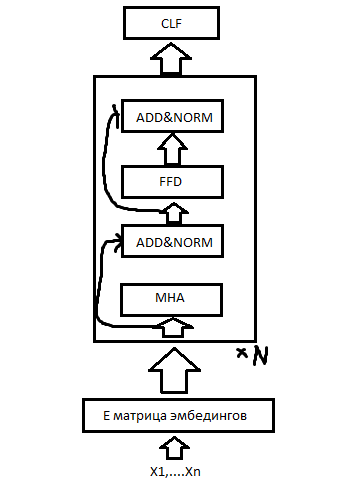

In [66]:
import math

def pos_emb(max_len, d):
    pe = torch.zeros(max_len, d)
    position = torch.arange(0, max_len).unsqueeze(1)
    div =torch.exp(torch.arange(0, d, 2)) *-(math.log(1000.0) / d)
    pe[:, 0::2] = torch.sin(position * div)
    pe[:, 1::2] = torch.cos(position * div)
    return pe
    
class MLMTransformer(nn.Module):
    def __init__(self, d, vocab_size,  n_head, d_hid, n_blocks):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d, padding_idx = PAD)#по id получаем эмбединги
        # TODO pos embedings не смертельная необходимость
        Layers = [TransformerEncoderBlock(d, n_head, d_hid) for i in range(n_blocks)]
        self.enc = nn.Sequential(*Layers)# n трансформерных блоков
        self.clf = nn.Linear(d, vocab_size)    
            
    def forward(self, x_batch):
        # TODO padding
        out = self.emb(x_batch)
        out = out + pos_emb(out.shape[1], out.shape[2])
        out = self.enc(out)
        out = self.clf(out)
        return out

In [44]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,d, n_head, d_hid):
        super().__init__()
        self.ln1 = nn.LayerNorm(d) #ADD&NORM
        self.ln2 = nn.LayerNorm(d)  #ADD&NORM
        self.mha = MultiHeadAttention(d, n_head)
        self.ffd = nn.Sequential(
            nn.Linear(d, d_hid),
            nn.ReLU(),
            nn.Linear(d_hid, d)
        )
        
    def forward(self, x):
        residual = x
        x = self.mha(x)
        x = self.ln1(x + residual)
        residual = x
        x = self.ffd(x)
        x = self.ln2(x + residual)
        return x
        

In [45]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d, n_head):
        super().__init__()
        self.heads = nn.ModuleList()
        for i in range(n_head):
            self.heads.append(OneHeadAttention(d, n_head))
        self.out_proj = nn.Linear(n_head*d, d, bias = True)
    def forward(self, x):
        out_heads = []
        for head in self.heads:
            out_heads.append(head(x))
        out = torch.cat(out_heads, dim = -1)
        out = self.out_proj(out)
        return out  

In [46]:
class OneHeadAttention(nn.Module):
        def __init__(self, d, n_head):
            super().__init__()
            self.q = nn.Linear(d, d, bias = False)
            self.k = nn.Linear(d, d, bias = False)
            self.v = nn.Linear(d, d, bias = False)
            self.d = d
        def forward(self, x):
            q = self.q(x)
            k = self.k(x)
            v = self.v(x)
            out = torch.matmul(q.transpose(1,2), k)/ self.d **0.5 #.transpose(1,2) меняем размерности местами
            out = F.softmax(out, dim = -1)
            out = out @ v.transpose(1, 2)
            return out.transpose(1, 2)       
            

In [47]:
model = ClassificationTransformer(vocab_size = len(vocab),
                                  d = 32, n_head = 4, d_hid = 64, 
                                  n_blocks = 2, n_classes = 3
                                 )

out = model(batch[0])
out.shape

torch.Size([8, 3])

## 3 Train loop

In [48]:
from sklearn.metrics import f1_score

def test(model, test_df):
    ds = MyDataset(test_df, vocab)
    dl = DataLoader(ds, batch_size =8, shuffle = False, collate_fn = collate_fn)
    y_preds = []
    for x_batch, y_batch in dl:
        
        y_pred = model(x_batch)
        y_preds.append(y_pred) # список тензеров 8*3
    
    y_preds = torch.cat(y_preds, dim = 0)
    torch.argmax(y_preds, dim =-1).numpy() #нужно взять номер максимального
    return f1_score(test_df['label'], y_preds, average='micro')
        

In [49]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
lr=0.001
num_epoch = 10

dl = DataLoader(ds, batch_size = 8, shuffle = True, collate_fn = collate_fn)
model = ClassificationTransformer(vocab_size = len(vocab),
                                  d = 32, n_head = 4, d_hid = 64, 
                                  n_blocks = 2, n_classes = 3
                                 )
opt = optim.Adam(model.parameters(), lr = lr)

for epoch in range(num_epoch):
    model.train()
    for num_step, (x_batch, y_batch) in tqdm(enumerate(dl)):
        opt.zero_grad()
        y_pred = model(x_batch)
        loss = F.cross_entropy(y_pred, y_batch) #внутри сам считает softma[ ]
        loss.backward()
        opt.step()
        if num_step %10000 == 0:
            print(loss.item())
        
    model.eval()
    score = test(model, test_df)
    print(epoch, score)

In [ ]:
lr=0.001
num_epoch = 10
p = 0.15

dl = DataLoader(ds, batch_size = 8, shuffle = True, collate_fn = collate_fn)
model = MLMTransformer(vocab_size = len(vocab),
                                  d = 32, n_head = 4, d_hid = 64, 
                                  n_blocks = 2
                                 )
opt = optim.Adam(model.parameters(), lr = lr)

for epoch in range(num_epoch):
    model.train()
    for num_step, (x_batch, y_batch) in tqdm(enumerate(dl)):
        opt.zero_grad()
        x_batch = x_batch['x']
        # 1-сгенерировать маску с размерностью как ч батча
        mask = torch.rand(x_batch.shape) < p
        # 2-меняем вход для модели
        x_batch_ = x_batch.clone()
        x_batch[mask] = vocab.MASK
        # 3-надо скопировать батч чтобы использовать как y в loss
        y_pred = model(x_batch)
        loss = F.cross_entropy(y_pred.transpose(1,2), x_batch, reduction='none' ) #внутри сам считает softma[ ]
        loss = (loss * mask.float()).sum()/mask.sum()
        loss.backward()
        opt.step()
        if num_step %100 == 0:
            print(loss.item())
        
    model.eval()
    score = test(model, test_df)
    print(epoch, score)